In [1]:
import re
import pandas as pd
import itertools
import random
import json
from collections import Counter


In [2]:
dataset = []
with open('../data/ViMedNER.txt', 'r', encoding='utf-8') as f:
    for dong in f:
        dataset.append(json.loads(dong.strip()))

In [3]:
df = pd.DataFrame(dataset)
df.head()

,id,text,label,Comments
0,3504,kháng sinh dự phòng nếu đã được chỉ định trong...,"[[135, 163, DISEASE]]",[]
1,3505,ngày nay các chuyên gia tin rằng viêm nội tâm ...,"[[33, 49, DISEASE], [101, 109, CAUSE]]",[]
2,3506,hướng dẫn hiện nay khuyến cáo điều trị kháng s...,"[[129, 157, DISEASE]]",[]
3,3507,bác sĩ vẫn có thể khuyên nên dùng kháng sinh p...,"[[84, 100, TREATMENT]]",[]
4,3508,đối với hầu hết những người có thông liên thất...,"[[31, 46, DISEASE], [160, 176, DISEASE]]",[]


In [4]:
df = df.drop(columns='Comments')
df['text'] = df['text'].str.strip()

Câu có hơn 512 token

In [5]:
df['token_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))
ket_qua = df[df['token_count'] > 512]
print(f"Số lượng dòng có hơn 512 token: {len(ket_qua)}")
print(ket_qua[['id', 'token_count']])
df['token_count']


Số lượng dòng có hơn 512 token: 2
         id  token_count
6972  12466          563
7005  12517          618


0       43
1       42
2       34
3       25
4       39
        ..
7744    44
7745    28
7746    28
7747    34
7748    25
Name: token_count, Length: 7749, dtype: int64

Câu chỉ có 1 label 

In [6]:
df['num_labels'] = df['label'].apply(len)
one_label_rows = df[df['num_labels'] == 1]

In [7]:
print(f"Tổng số dòng trong file: {len(df)}")
print(f"Số dòng có đúng 1 label: {len(one_label_rows)}")

Tổng số dòng trong file: 7749
Số dòng có đúng 1 label: 2880


In [8]:
if not one_label_rows.empty:
    print("\nVí dụ các dòng có 1 label:")
    print(one_label_rows[['id', 'label', 'num_labels']].head())


Ví dụ các dòng có 1 label:
     id                   label  num_labels
0  3504   [[135, 163, DISEASE]]           1
2  3506   [[129, 157, DISEASE]]           1
3  3507  [[84, 100, TREATMENT]]           1
6  3513     [[70, 85, DISEASE]]           1
7  3516     [[81, 96, DISEASE]]           1


Entity Co-occurrence

In [9]:
import pandas as pd
from itertools import combinations

def analyze_re_potential(row):
    labels = row['label']
    num_entities = len(labels)
    if num_entities < 2:
        return {
            "valid_for_re": False,
            "entity_count": num_entities,
            "pairs": []
        }
    
    entity_types = [lbl[2] for lbl in labels]
    pairs = list(combinations(entity_types, 2))
    
    return {
        "valid_for_re": True,
        "entity_count": num_entities,
        "pairs": pairs
    }

df = df.reset_index(drop=True)

df = df.loc[:, ~df.columns.duplicated()]

analysis = df.apply(analyze_re_potential, axis=1, result_type='expand')
df = pd.concat([df, analysis], axis=1)

print("Đã xử lý xong! Kích thước dữ liệu hiện tại:", df.shape)

re_data = df[df['valid_for_re'] == True]
print("=== ĐÁNH GIÁ KHẢ NĂNG LÀM RELATION EXTRACTION ===")
print(f"1. Tổng số câu ban đầu: {len(df)}")
print(f"2. Số câu CÓ THỂ chứa quan hệ (>= 2 entities): {len(re_data)} ({len(re_data)/len(df)*100:.1f}%)")
print("-" * 30)

if not re_data.empty:
    all_pairs = [pair for row_pairs in re_data['pairs'] for pair in row_pairs]
    sorted_pairs = [tuple(sorted(p)) for p in all_pairs] 
    
    from collections import Counter
    pair_counts = Counter(sorted_pairs)
    
    print("3. Top các cặp thực thể xuất hiện cùng nhau (Tiềm năng quan hệ):")
    for pair, count in pair_counts.most_common(10):
        print(f"   - {pair[0]} <---> {pair[1]}: {count} lần")

    print("-" * 30)
    print("Ví dụ 1 câu đạt chuẩn RE:")
    sample = re_data.iloc[0]
    print(f"ID: {sample['id']}")
    print(f"Text: {sample['text']}")
    print(f"Labels: {sample['label']}")
    print(f"Các cặp tiềm năng: {sample['pairs']}")
else:
    print("Cảnh báo: Không có dòng nào có từ 2 thực thể trở lên!")

Đã xử lý xong! Kích thước dữ liệu hiện tại: (7749, 8)
=== ĐÁNH GIÁ KHẢ NĂNG LÀM RELATION EXTRACTION ===
1. Tổng số câu ban đầu: 7749
2. Số câu CÓ THỂ chứa quan hệ (>= 2 entities): 4869 (62.8%)
------------------------------
3. Top các cặp thực thể xuất hiện cùng nhau (Tiềm năng quan hệ):
   - DISEASE <---> DISEASE: 10640 lần
   - SYMPTOM <---> SYMPTOM: 7614 lần
   - DISEASE <---> SYMPTOM: 6162 lần
   - TREATMENT <---> TREATMENT: 3116 lần
   - DISEASE <---> TREATMENT: 2418 lần
   - DIAGNOSTIC <---> DISEASE: 2029 lần
   - CAUSE <---> DISEASE: 1926 lần
   - DIAGNOSTIC <---> DIAGNOSTIC: 1493 lần
   - CAUSE <---> CAUSE: 1277 lần
   - SYMPTOM <---> TREATMENT: 754 lần
------------------------------
Ví dụ 1 câu đạt chuẩn RE:
ID: 3505
Text: ngày nay các chuyên gia tin rằng viêm nội tâm mạc nhiều hơn với khả năng xảy ra từ việc tiếp xúc với vi trùng một cách ngẫu nhiên hơn từ một thủ thuật nha khoa hoặc phẫu thuật điển hình .
Labels: [[33, 49, 'DISEASE'], [101, 109, 'CAUSE']]
Các cặp tiềm năng: 

In [10]:
# Tìm xem dòng nào có 'pairs' bị lỗi (độ dài < 2)
def has_bad_pairs(pairs):
    if not isinstance(pairs, list): return True
    for p in pairs:
        if len(p) < 2: return True
    return False

# Lọc ra các dòng lỗi
error_rows = df[df['pairs'].apply(has_bad_pairs)]

if not error_rows.empty:
    print(f"Phát hiện {len(error_rows)} dòng có cặp quan hệ bị lỗi (không đủ 2 thực thể/cặp).")
    print("Ví dụ dòng lỗi:", error_rows['pairs'].head())
    
    # Bạn có thể muốn loại bỏ các dòng này khỏi tập dữ liệu RE
    # df = df[~df['pairs'].apply(has_bad_pairs)]
else:
    print("Dữ liệu sạch, lỗi trước đó có thể do giá trị Null.")

Dữ liệu sạch, lỗi trước đó có thể do giá trị Null.


In [11]:
def calculate_priority_safe(pairs):
    # [An toàn 1] Nếu ô dữ liệu là NaN hoặc không phải list -> trả về 0
    if not isinstance(pairs, list):
        return 0
    
    score = 0
    for p in pairs:
        # [An toàn 2] Nếu p không đủ 2 phần tử (ví dụ chỉ có 1 nhãn) -> Bỏ qua
        if len(p) < 2:
            continue
            
        # Logic tính điểm cũ
        try:
            p_sorted = tuple(sorted(p))
            
            # Ưu tiên cao nhất cho các cặp khác loại quan trọng
            if p_sorted in [('DISEASE', 'SYMPTOM'), ('DISEASE', 'TREATMENT'), ('CAUSE', 'DISEASE')]:
                score += 3
            # Ưu tiên vừa cho các cặp chẩn đoán
            elif p_sorted in [('DIAGNOSTIC', 'DISEASE')]:
                score += 2
            # Ít ưu tiên cho cặp cùng loại (thường là liệt kê)
            elif p[0] == p[1]:
                score += 0.5 
            else:
                score += 1
        except Exception:
            continue # Bỏ qua nếu có lỗi bất ngờ khác
            
    return score

df['priority_score'] = df['pairs'].apply(calculate_priority_safe)

print("Đã tính điểm xong mà không bị lỗi!")

Đã tính điểm xong mà không bị lỗi!


In [12]:
top_data = df.sort_values(by='priority_score', ascending=False).head(1000).copy()

print(f"Đã chọn được {len(top_data)} câu.")

Đã chọn được 1000 câu.


In [13]:
top_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 7005 to 899
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1000 non-null   int64  
 1   text            1000 non-null   object 
 2   label           1000 non-null   object 
 3   token_count     1000 non-null   int64  
 4   num_labels      1000 non-null   int64  
 5   valid_for_re    1000 non-null   bool   
 6   entity_count    1000 non-null   int64  
 7   pairs           1000 non-null   object 
 8   priority_score  1000 non-null   float64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 71.3+ KB


In [14]:
top_data.head() 

,id,text,label,token_count,num_labels,valid_for_re,entity_count,pairs,priority_score
7005,12517,trong đó các nguyên nhân thường gặp gồm có : c...,"[[67, 91, DISEASE], [94, 102, DISEASE], [105, ...",618,61,True,61,"[(DISEASE, DISEASE), (DISEASE, DISEASE), (DISE...",2730.0
7568,13262,nguyên nhân bệnh thiếu máu do thiếu vitamin b1...,"[[12, 26, DISEASE], [30, 47, CAUSE], [95, 112,...",470,32,True,32,"[(DISEASE, CAUSE), (DISEASE, CAUSE), (DISEASE,...",907.5
5777,11030,tuổi : đa số bệnh nhân ung thư túi mật được ch...,"[[23, 38, DISEASE], [82, 97, DISEASE], [175, 1...",355,32,True,32,"[(DISEASE, DISEASE), (DISEASE, DISEASE), (DISE...",848.0
7370,13002,"triệu chứng sốt , sưng vùng thoát vị kèm đỏ , ...","[[12, 15, SYMPTOM], [18, 36, SYMPTOM], [54, 61...",490,29,True,29,"[(SYMPTOM, SYMPTOM), (SYMPTOM, SYMPTOM), (SYMP...",710.0
6910,12389,tuy nhiên bệnh trĩ không phải luôn luôn đi ngo...,"[[10, 18, DISEASE], [40, 55, SYMPTOM], [59, 86...",397,28,True,28,"[(DISEASE, SYMPTOM), (DISEASE, SYMPTOM), (DISE...",661.5


In [17]:
def extract_pairs_for_eda(row):
    """
    Hàm này tách các cặp thực thể từ một dòng dữ liệu để phân tích.
    Tính thêm khoảng cách (distance) giữa 2 thực thể để đánh giá độ khó.
    """
    text = row['text']
    labels = row['label'] # List các tuple (start, end, label)
    
    # Sắp xếp label theo vị trí xuất hiện để tính khoảng cách cho đúng
    labels = sorted(labels, key=lambda x: x[0])
    
    pairs_data = []
    
    # Tạo tất cả các cặp có thể trong câu (nhưng giới hạn cửa sổ nếu cần, ở đây lấy hết)
    for i, label1 in enumerate(labels):
        for j, label2 in enumerate(labels):
            if i >= j: continue # Tránh trùng lặp và cặp với chính nó
            
            start1, end1, type1 = label1
            start2, end2, type2 = label2
            
            # Tính khoảng cách ký tự (hoặc có thể tính bằng token nếu muốn kỹ hơn)
            distance = start2 - end1 
            
            # Sắp xếp tên loại để (DISEASE, SYMPTOM) giống (SYMPTOM, DISEASE) khi thống kê
            sorted_types = sorted([type1, type2])
            pair_type_str = f"{sorted_types[0]} - {sorted_types[1]}"
            
            pairs_data.append({
                'original_id': row['id'],
                'text': text,
                'entity_1': text[start1:end1],
                'type_1': type1,
                'entity_2': text[start2:end2],
                'type_2': type2,
                'pair_type': pair_type_str,
                'distance_char': distance
            })
            
    return pairs_data

# Flatten dữ liệu ra thành từng dòng pair
all_pairs = []
for _, row in top_data.iterrows():
    all_pairs.extend(extract_pairs_for_eda(row))

df_pairs = pd.DataFrame(all_pairs)

print(f"Tổng số cặp quan hệ tiềm năng trong 1000 câu: {len(df_pairs)}")
df_pairs.head()

Tổng số cặp quan hệ tiềm năng trong 1000 câu: 28832


,original_id,text,entity_1,type_1,entity_2,type_2,pair_type,distance_char
0,12517,trong đó các nguyên nhân thường gặp gồm có : c...,viêm cầu thận cấp và mạn,DISEASE,sỏi thận,DISEASE,DISEASE - DISEASE,3
1,12517,trong đó các nguyên nhân thường gặp gồm có : c...,viêm cầu thận cấp và mạn,DISEASE,hẹp động mạch thận,DISEASE,DISEASE - DISEASE,14
2,12517,trong đó các nguyên nhân thường gặp gồm có : c...,viêm cầu thận cấp và mạn,DISEASE,u tủy thượng thận,DISEASE,DISEASE - DISEASE,60
3,12517,trong đó các nguyên nhân thường gặp gồm có : c...,viêm cầu thận cấp và mạn,DISEASE,cường aldosteron,DISEASE,DISEASE - DISEASE,80
4,12517,trong đó các nguyên nhân thường gặp gồm có : c...,viêm cầu thận cấp và mạn,DISEASE,cushing,DISEASE,DISEASE - DISEASE,99


/var/folders/55/39kr7xts3xzc25bk7qvpk0j80000gn/T/ipykernel_5205/1240997922.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sys.barplot(data=pair_counts.head(10), x='Frequency', y='Pair Type', palette='viridis')


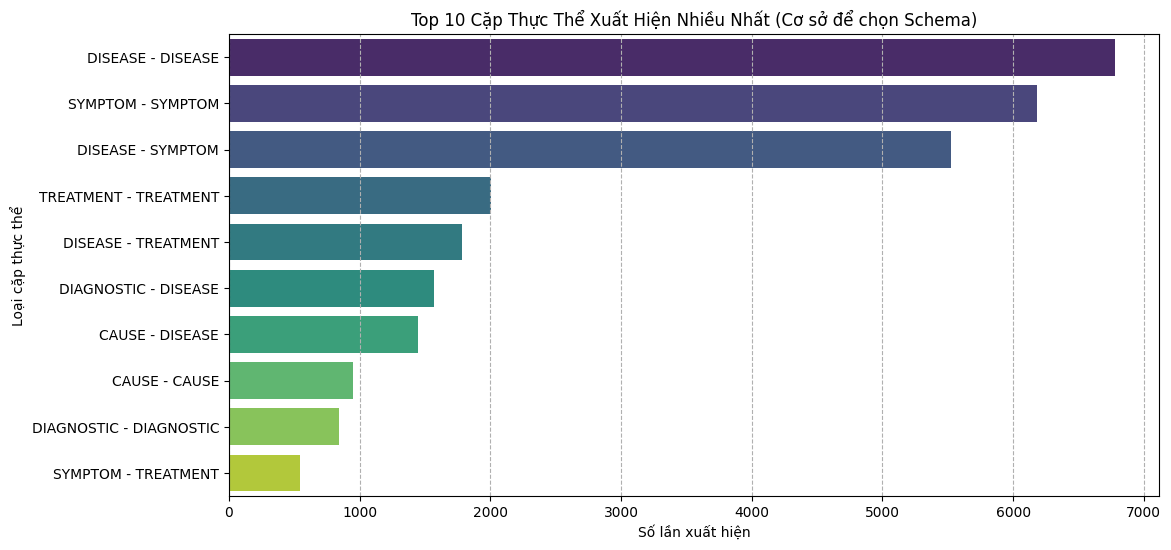

Chi tiết tần suất các cặp:
                  Pair Type  Frequency
0         DISEASE - DISEASE       6776
1         SYMPTOM - SYMPTOM       6184
2         DISEASE - SYMPTOM       5523
3     TREATMENT - TREATMENT       2003
4       DISEASE - TREATMENT       1785
5      DIAGNOSTIC - DISEASE       1569
6           CAUSE - DISEASE       1447
7             CAUSE - CAUSE        953
8   DIAGNOSTIC - DIAGNOSTIC        841
9       SYMPTOM - TREATMENT        543
10     DIAGNOSTIC - SYMPTOM        492
11          CAUSE - SYMPTOM        386
12   DIAGNOSTIC - TREATMENT        173
13        CAUSE - TREATMENT        120
14       CAUSE - DIAGNOSTIC         37


In [19]:
from matplotlib import pyplot as plt
import seaborn  as sys

pair_counts = df_pairs['pair_type'].value_counts().reset_index()
pair_counts.columns = ['Pair Type', 'Frequency']

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sys.barplot(data=pair_counts.head(10), x='Frequency', y='Pair Type', palette='viridis')
plt.title('Top 10 Cặp Thực Thể Xuất Hiện Nhiều Nhất (Cơ sở để chọn Schema)')
plt.xlabel('Số lần xuất hiện')
plt.ylabel('Loại cặp thực thể')
plt.grid(axis='x', linestyle='--')
plt.show()

# Hiển thị bảng số liệu chi tiết
print("Chi tiết tần suất các cặp:")
print(pair_counts.head(15))

In [21]:
detailed_schema = {
    "DISEASE - SYMPTOM": {
        "rel_name": "HAS_MANIFESTATION",
        "direction": "Subject (Disease) -> Object (Symptom)",
        "definition": "Bệnh lý gây ra hoặc biểu hiện bằng triệu chứng cụ thể.",
        "ref_standard": "UMLS: manifestation_of | SNOMED CT: Finding site",
        "ref_paper": "Zhou et al. (2014) - Clinical Relation Extraction",
        "example": "Sốt xuất huyết (S) gây phát ban (O)."
    },
    "CAUSE - DISEASE": {
        "rel_name": "CAUSES", 
        "direction": "Subject (Cause) -> Object (Disease)",
        "definition": "Nguyên nhân bên ngoài hoặc tác nhân sinh học dẫn đến bệnh lý.",
        "ref_standard": "UMLS: causes | BioCreative V CDR Task (Chemical-induced Disease)",
        "ref_paper": "Wei et al. (2015) - CDR Corpus",
        "example": "Virus HPV (S) gây ung thư cổ tử cung (O)."
    },
    "DISEASE - TREATMENT": {
        "rel_name": "TREATED_WITH",
        "direction": "Subject (Disease) -> Object (Treatment)", # Hoặc đảo lại tùy bạn chọn
        "definition": "Phương pháp điều trị, thuốc hoặc thủ thuật được dùng để chữa bệnh.",
        "ref_standard": "i2b2 2010: TrCP (Treatment Cures Problem)",
        "ref_paper": "Uzuner et al. (2011) - i2b2/VA Challenge",
        "example": "Viêm phổi (S) điều trị bằng kháng sinh (O)."
    },
    "DIAGNOSTIC - DISEASE": {
        "rel_name": "REVEALS",
        "direction": "Subject (Diagnostic) -> Object (Disease)",
        "definition": "Phương pháp chẩn đoán phát hiện ra bệnh lý.",
        "ref_standard": "i2b2 2010: TeCP (Test reveals Problem)",
        "ref_paper": "Uzuner et al. (2011) - i2b2/VA Challenge",
        "example": "Sinh thiết (S) cho thấy tế bào ung thư (O)."
    }
}

# Tạo DataFrame hiển thị đẹp
schema_df = pd.DataFrame.from_dict(detailed_schema, orient='index')

# Reset index để lấy Pair Type làm cột
schema_df.reset_index(inplace=True)
schema_df.rename(columns={'index': 'Entity Pair'}, inplace=True)

print("=== SCHEMA QUAN HỆ CHÍNH THỨC (CÓ THAM CHIẾU) ===")
pd.set_option('display.max_colwidth', None)
display(schema_df[['Entity Pair', 'rel_name', 'definition', 'ref_standard']])

# Xuất ra CSV để đưa vào báo cáo/paper
# schema_df.to_csv('relation_schema_with_refs.csv', index=False)

=== SCHEMA QUAN HỆ CHÍNH THỨC (CÓ THAM CHIẾU) ===


,Entity Pair,rel_name,definition,ref_standard
0,DISEASE - SYMPTOM,HAS_MANIFESTATION,Bệnh lý gây ra hoặc biểu hiện bằng triệu chứng cụ thể.,UMLS: manifestation_of | SNOMED CT: Finding site
1,CAUSE - DISEASE,CAUSES,Nguyên nhân bên ngoài hoặc tác nhân sinh học dẫn đến bệnh lý.,UMLS: causes | BioCreative V CDR Task (Chemical-induced Disease)
2,DISEASE - TREATMENT,TREATED_WITH,"Phương pháp điều trị, thuốc hoặc thủ thuật được dùng để chữa bệnh.",i2b2 2010: TrCP (Treatment Cures Problem)
3,DIAGNOSTIC - DISEASE,REVEALS,Phương pháp chẩn đoán phát hiện ra bệnh lý.,i2b2 2010: TeCP (Test reveals Problem)


Human labeling...

In [15]:
import json

label_studio_data = []

for idx, row in top_data.iterrows():
    text = row['text']
    original_labels = row['label'] # Dạng [(start, end, label), ...]
    
    # 1. Tạo danh sách kết quả (các thực thể đã gán nhãn)
    results = []
    for start, end, label_type in original_labels:
        results.append({
            "from_name": "label", # Tên thẻ Labels trong config XML (quan trọng)
            "to_name": "text",    # Tên thẻ Text trong config XML
            "type": "labels",
            "value": {
                "start": int(start), # Label Studio bắt buộc int chuẩn, không phải numpy int
                "end": int(end),
                "text": text[start:end],
                "labels": [label_type]
            }
        })
    
    task = {
        "data": {
            "text": text,
            "ref_id": str(row['id']) # Lưu id gốc để sau này map lại
        }
    }
    
    # 3. Nếu có nhãn, thêm vào phần predictions (dự đoán sẵn)
    if results:
        task["predictions"] = [{
            "model_version": "v1_pre_label",
            "score": 0.5, # Giả định độ tin cậy, có thể bỏ qua
            "result": results
        }]
        
    label_studio_data.append(task)

# Xuất ra file JSON
with open('data_for_label_studio.json', 'w', encoding='utf-8') as f:
    json.dump(label_studio_data, f, ensure_ascii=False, indent=4)

print(f"Đã xuất {len(label_studio_data)} mẫu ra file 'data_for_label_studio.json'")

Đã xuất 1000 mẫu ra file 'data_for_label_studio.json'


In [16]:
re_records = []

for idx, row in top_data.iterrows():
    text = row['text']
    labels = row['label']

    entities = []
    for start, end, label_type in labels:
        entity_text = text[start:end]
        entities.append({'start': start, 'end': end, 'type': label_type, 'text': entity_text})
    
    from itertools import combinations
    if len(entities) >= 2:
        for e1, e2 in combinations(entities, 2):
            re_records.append({
                'original_id': row['id'],
                'text': text,
                'entity_1_text': e1['text'],
                'entity_1_type': e1['type'],
                'entity_2_text': e2['text'],
                'entity_2_type': e2['type'],
                'relation_label': None
            })
re_df = pd.DataFrame(re_records)

re_df

,original_id,text,entity_1_text,entity_1_type,entity_2_text,entity_2_type,relation_label
0,12517,trong đó các nguyên nhân thường gặp gồm có : c...,viêm cầu thận cấp và mạn,DISEASE,sỏi thận,DISEASE,None
1,12517,trong đó các nguyên nhân thường gặp gồm có : c...,viêm cầu thận cấp và mạn,DISEASE,hẹp động mạch thận,DISEASE,None
2,12517,trong đó các nguyên nhân thường gặp gồm có : c...,viêm cầu thận cấp và mạn,DISEASE,u tủy thượng thận,DISEASE,None
3,12517,trong đó các nguyên nhân thường gặp gồm có : c...,viêm cầu thận cấp và mạn,DISEASE,cường aldosteron,DISEASE,None
4,12517,trong đó các nguyên nhân thường gặp gồm có : c...,viêm cầu thận cấp và mạn,DISEASE,cushing,DISEASE,None
...,...,...,...,...,...,...,...
28827,4784,loại thuốc octreotide gọi là ( sandostatin ) t...,thuốc octreotide,TREATMENT,liệu pháp nội soi,TREATMENT,None
28828,4784,loại thuốc octreotide gọi là ( sandostatin ) t...,thuốc octreotide,TREATMENT,chảy máu tĩnh mạch thực quản,DISEASE,None
28829,4784,loại thuốc octreotide gọi là ( sandostatin ) t...,sandostatin,TREATMENT,liệu pháp nội soi,TREATMENT,None
28830,4784,loại thuốc octreotide gọi là ( sandostatin ) t...,sandostatin,TREATMENT,chảy máu tĩnh mạch thực quản,DISEASE,None
